Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
Обернуть его в Dataloader
Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass

In [3]:
class MyDataSet(Dataset):

  def __init__(self, init_dataset, transform=None):
    self._base_dataset = init_dataset
    self.transform = transform

  def __len__(self):
    return len(self._base_dataset)

  def __getitem__(self, idx):
    item = self._base_dataset[idx]

    if self.transform is not None:
      dataset = self.transform(self._base_dataset)

    return dataset


In [4]:
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression, self).__init__()

        self.hidden1 = nn.Linear(in_features=8, out_features=100, bias=True)
        self.bn1 = nn.BatchNorm1d(100)
        self.dp1 = nn.Dropout(0.25)
        self.hidden2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.dp2 = nn.Dropout(0.25)
        self.hidden3 = nn.Linear(100, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.dp3 = nn.Dropout(0.25)
        self.predict = nn.Linear(50, 1)


    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dp1(x)
        x = self.bn1(x)
        x = F.relu(self.hidden2(x))
        x = self.dp2(x)
        x = self.bn2(x)
        x = F.relu(self.hidden3(x))
        x = self.dp3(x)
        x = self.bn3(x)
        output = self.predict(x)

        return output[:, 0]


In [5]:
def train_my_net(net):
  train_loss_all = []
  for epoch in range(30):
      train_loss = 0
      train_num = 0

      for step, (b_x, b_y) in enumerate(train_loader):
          output = my_net(b_x)
          loss = loss_func(output, b_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * b_x.size(0)
          train_num += b_x.size(0)
      train_loss_all.append(train_loss / train_num)

  return train_loss_all

In [6]:
def plot_train_loss(train_loss):
  plt.figure(figsize = (8, 6))
  plt.plot(train_loss, 'ro-', label = 'Train loss')
  plt.legend()
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.show()


In [7]:
def test_mae(net):
  y_pre = net(X_test_t)
  y_pre = y_pre.data.numpy()
  mae_sgd = mean_absolute_error(y_test, y_pre)
  print(f'МАЕ на тесте: {mae_sgd:.3f}')


In [8]:
housedata = fetch_california_housing()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(housedata.data, housedata.target, test_size = 0.25, random_state = 13)

In [10]:
# Стандартизация
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)


In [11]:
# данные в читабельную таблицу
housedatadf = pd.DataFrame(data=X_train_s, columns = housedata.feature_names)
housedatadf['target'] = y_train
housedatadf.head(3)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,-0.181483,0.579137,-0.340021,-0.004463,-0.065383,-0.087113,-0.671762,0.675607,2.680
1,-0.468327,0.579137,-0.436304,-0.200565,-0.187060,0.012248,-0.685728,0.605994,1.902
2,-1.141668,-1.409735,6.179161,7.136066,-1.184805,-0.125634,2.112156,-0.741514,1.375


In [12]:
# данные в тензор
X_train_t = torch.from_numpy(X_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test_s.astype(np.float32))
y_test_t = torch.from_numpy(X_test.astype(np.float32))


In [13]:
train_data = TensorDataset(X_train_t, y_train_t)
test_data = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(dataset = train_data, batch_size = 64,
                               shuffle = True, num_workers = 1)

In [14]:
my_net = MLPregression()

In [15]:
optimizer = SGD(my_net.parameters(), lr = 0.01)
loss_func = nn.MSELoss()

sgd_loss = train_my_net(my_net)

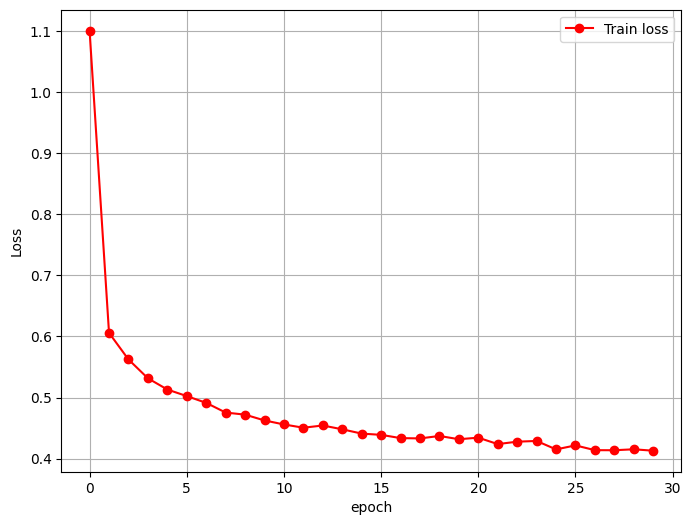

In [16]:
plot_train_loss(sgd_loss)

In [17]:
test_mae(my_net)

МАЕ на тесте: 0.462


In [18]:
optimizer = RMSprop(my_net.parameters(), lr = 0.01)
loss_RMS = train_my_net(my_net)

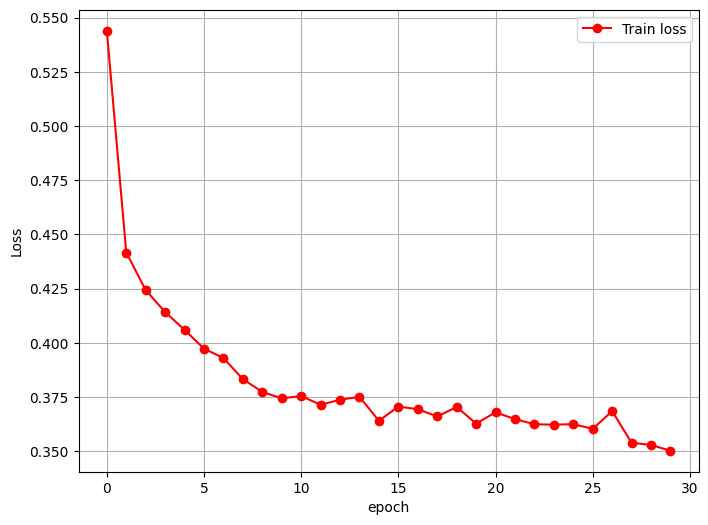

In [19]:
plot_train_loss(loss_RMS)

In [20]:
test_mae(my_net)

МАЕ на тесте: 0.419


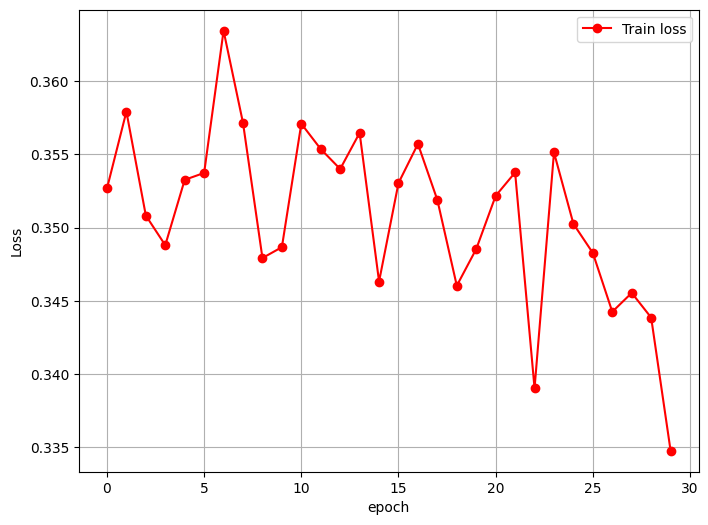

In [21]:
optimizer = Adam(my_net.parameters(), lr = 0.01)
loss_Adam = train_my_net(my_net)
plot_train_loss(loss_Adam)

In [22]:
test_mae(my_net)

МАЕ на тесте: 0.451


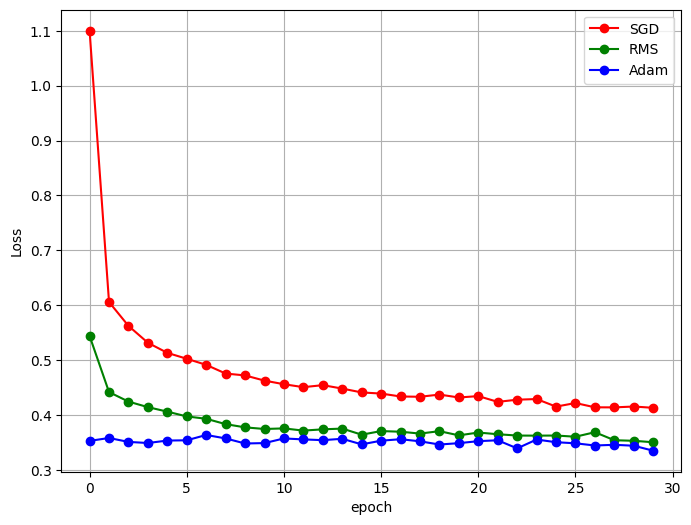

In [23]:
plt.figure(figsize=(8,6))
plt.plot(sgd_loss, 'ro-', label = 'SGD')
plt.plot(loss_RMS, 'go-', label = 'RMS')
plt.plot(loss_Adam, 'bo-', label = 'Adam')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
test_mae(my_net)

МАЕ на тесте: 0.449
